# Prikupljanje i predobrada podataka
## Augmentacija slika
### Petra Milosavljević 1582

In [4]:
import os

import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder

In [5]:
classes = os.listdir('Garbage classification')
classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [6]:
transform_no_augment = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_with_augment = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.5),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.6),
    transforms.RandomApply([transforms.RandomGrayscale(p=0.1)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_no_augment = ImageFolder('Garbage classification', transform=transform_no_augment)
dataset_with_augment = ImageFolder('Garbage classification', transform=transform_with_augment)

In [7]:
train_ds_no_augment, test_ds_no_augment = random_split(dataset_no_augment, [0.8, 0.2])
train_ds_with_augment, test_ds_with_augment = random_split(dataset_with_augment, [0.8, 0.2])

batch_size = 32
device = "cpu"
num_epochs = 10
opt_func = torch.optim.Adam
learning_rate = 5.5e-5

train_dl_no_augment = DataLoader(
    train_ds_no_augment, batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_dl_no_augment = DataLoader(test_ds_no_augment, batch_size, num_workers=4, pin_memory=True)

train_dl_with_augment = DataLoader(
    train_ds_with_augment, batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_dl_with_augment = DataLoader(test_ds_with_augment, batch_size, num_workers=4, pin_memory=True)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    train_loss_history = []

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return train_loss_history

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return accuracy, precision, recall, f1

In [13]:
def run_training(train_loader, test_loader, description):
    print(f"\nTraining with {description}")

    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = train(model, train_loader, criterion, optimizer, num_epochs)
    test_accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
    
    print(f'Test Accuracy with {description}: {test_accuracy:.2f}%')
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')
    
    return train_loss_history, test_accuracy, precision, recall, f1

In [14]:
train_loss_no_augment, accuracy_no_augment, precision_no_augment, recall_no_augment, f1_no_augment = run_training(train_dl_no_augment, test_dl_no_augment, "No Augmentation")


Training with No Augmentation
Epoch [1/10], Loss: 1.4138
Epoch [2/10], Loss: 1.1084
Epoch [3/10], Loss: 0.9527
Epoch [4/10], Loss: 0.8131
Epoch [5/10], Loss: 0.7319
Epoch [6/10], Loss: 0.6353
Epoch [7/10], Loss: 0.5596
Epoch [8/10], Loss: 0.4958
Epoch [9/10], Loss: 0.4255
Epoch [10/10], Loss: 0.3634
Test Accuracy with No Augmentation: 67.52%
Precision: 0.69, Recall: 0.63, F1 Score: 0.64


In [15]:
train_loss_with_augment, accuracy_with_augment, precision_with_augment, recall_with_augment, f1_with_augment = run_training(train_dl_with_augment, test_dl_no_augment,  "Data Augmentation")


Training with Data Augmentation
Epoch [1/10], Loss: 1.5320
Epoch [2/10], Loss: 1.3416
Epoch [3/10], Loss: 1.3021
Epoch [4/10], Loss: 1.2112
Epoch [5/10], Loss: 1.1834
Epoch [6/10], Loss: 1.1358
Epoch [7/10], Loss: 1.0928
Epoch [8/10], Loss: 1.0748
Epoch [9/10], Loss: 1.0586
Epoch [10/10], Loss: 1.0463
Test Accuracy with Data Augmentation: 71.88%
Precision: 0.72, Recall: 0.68, F1 Score: 0.69


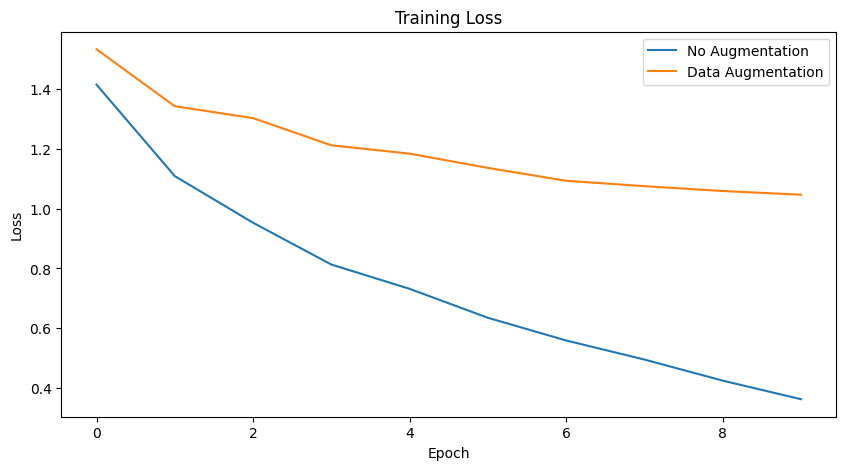

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_no_augment, label='No Augmentation')
plt.plot(train_loss_with_augment, label='Data Augmentation')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
results = []
results.append({
        "Augmentation": "NO",
        "Accuracy": accuracy_no_augment,
        "Precision": precision_no_augment,
        "Recall": recall_no_augment,
        "F1 score": f1_no_augment,
    })

results.append({
        "Augmentation": "YES",
        "Accuracy": accuracy_with_augment,
        "Precision": precision_with_augment,
        "Recall": recall_with_augment,
        "F1 score": f1_with_augment,
    })

results_df = pd.DataFrame(results)

results_df

,Augmentation,Accuracy,Precision,Recall,F1 score
0,NO,67.524752,0.686427,0.632917,0.640984
1,YES,71.881188,0.721203,0.676128,0.686050


Iz grafika training loss-a vidimo da je modelu 'teže' u toku treninga, tj. da je loss veći, ukoliko koristimo augmentaciju. To ima smisla, jer smo augmentacijama dodali dosta varijateta u dataset i samim tim ga učinili težim za model. Ali na metrikama dobijenim na test dataset-u vidimo da u slučaju kada imamo augmentaciju model bolje generalizuje, tj. bolje radi na podacima iz test seta koje nije video u toku treninga.
Metrike su povećane za nekoliko procenata, ali to bi moglo da bude i više uz ubacivanje nekih kompleksnijih augmentacija ili kompleksnijeg modela za klasifikaciju.